In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
seed = 42 # for testability purposes
keras.utils.set_random_seed(seed)
np.random.seed(seed)

2026-01-14 14:56:05.496017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/enrico/ComputerVision/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def size_to_change(img, size):
    if img.shape[0] <= img.shape[1]:
        return (256, int(np.floor(256 / img.shape[0] * img.shape[1])))
    else:
        return (int(np.floor(256 / img.shape[1] * img.shape[0])), 256)

def get_random_crop(img, cropX=224, cropY=224):
    max_x = img.shape[0] - cropX
    max_y = img.shape[1] - cropY

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = img[x: x + cropX, y: y + cropY]
    
    return crop

def load_data(url_directory, url_file, size=256, crop_dim=224, random_crop=False, central_crop=False, return_original=False):
    X = []
    y = []
    X_original = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, size_to_change(img, size))
            lbl = int(line_split[2].strip())

            if random_crop:
                crop = get_random_crop(img_resized, crop_dim, crop_dim) # is it fine even for val and test?
            elif central_crop: # center crop
                img_center = (img_resized.shape[0] // 2, img_resized.shape[1] // 2)
                crop_dim_half = crop_dim // 2
                crop = img_resized[
                    img_center[0] - crop_dim_half : img_center[0] - crop_dim_half + crop_dim,
                    img_center[1] - crop_dim_half : img_center[1] - crop_dim_half + crop_dim
                    ]
            else:
                crop = img_resized[:crop_dim, :crop_dim]

            X.append(crop)
            y.append(lbl)

            if return_original:
                img_resized_original = img_resized[:size, :size]
                X_original.append(img_resized_original)

    X = np.stack(X, axis=0)
    y = np.array(y)

    if return_original:
        return X, y, np.stack(X_original, axis=0)
    else:
        return X, y

In [3]:
def color_jittering(img, brightness_range=(-60, 60), saturation_range=(-60, 60)):
    rng = np.random.default_rng()
    img_hsv = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV)

    brightness = rng.integers(brightness_range[0], brightness_range[1])
    saturation = rng.integers(saturation_range[0], saturation_range[1])

    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] + saturation, 0, 255)
    img_hsv[:, :, 2] = np.clip(img_hsv[:, :, 2] + brightness, 0, 255)

    img_hsv = img_hsv.astype(np.uint8)

    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

def contrast_stretching(img, linear_contrast=True, gamma_correction=False, gamma_correction_parameter=1.0):
    img_copy = img.copy()
    
    if linear_contrast:
        p_min = np.percentile(img_copy, 5)
        p_max = np.percentile(img_copy, 95)

        img_copy = np.clip((255/(p_max - p_min)) * (img_copy - p_min), 0, 255).astype(np.uint8)

    if gamma_correction:
        img_copy = np.clip(255 * np.power(img_copy/255, gamma_correction_parameter), 0, 255).astype(np.uint8)

    return img_copy

def cutout(img, size=64, color=50):
    rng = np.random.default_rng()
    img_copy = img.copy()

    x = rng.integers(0, img.shape[0] - size)
    y = rng.integers(0, img.shape[1] - size)

    img_copy[x : x + size, y : y + size] = color
    return img_copy

def zoom(img, zoom_center=None, zoom_pixel=25):
    img_copy = img.copy()
    zoom_tot = img.shape[0] // 2 - zoom_pixel
    
    if zoom_center == None:
        cx = img_copy.shape[0] // 2
        cy = img_copy.shape[1] // 2
    else:
        cx = zoom_center[0]
        cy = zoom_center[y]
    
    pts1 = np.float32([(cx - zoom_tot, cy - zoom_tot), (cx + zoom_tot, cy - zoom_tot), (cx + zoom_tot, cy + zoom_tot), (cx - zoom_tot, cy + zoom_tot)])
    pts2 = np.float32([(0, 0), (img_copy.shape[0], 0), (img_copy.shape[0], img_copy.shape[1]), (0, img_copy.shape[1])])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(img_copy, M, (img.shape[0], img.shape[1]))
    
    return dst

In [4]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_train, y_train, X_train_original = load_data(url_directory, "train.txt", random_crop=True, return_original=True)
X_val, y_val = load_data(url_directory, "val.txt", central_crop=True)
X_test, y_test = load_data(url_directory, "test.txt", central_crop=True)

In [5]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)

#### DATA AUGMENTATION

In [27]:
X_train_augmented = []
y_train_augmented = []
n_crop = 1
rng = np.random.default_rng()

for idx, img in enumerate(X_train_original):
    lbl = y_train[idx]
    #print(f"shape original: {img.shape}")

    img_base = get_random_crop(img)
    X_train_augmented.append(img_base)
    y_train_augmented.append(lbl)
    #print(f"shape base: {img_base.shape}")

    img_base_zoom = zoom(img_base)
    X_train_augmented.append(img_base_zoom)
    y_train_augmented.append(lbl)

    if rng.integers(2) == 0: 
        img_base_flip = cv2.flip(img_base, 1)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)
    else:
        img_base_flip = cv2.flip(img_base, 0)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)

    #img_base_flip_both = cv2.flip(img_base, -1)
    #X_train_augmented.append(img_base_flip_both)
    #y_train_augmented.append(lbl)

    #if rng.integers(2) == 0:
    img_base_cutout = cutout(img_base_flip)
    X_train_augmented.append(img_base_cutout)
    y_train_augmented.append(lbl)

    for j in range(0, n_crop):
        img_new = get_random_crop(img)
        img_new = contrast_stretching(img_new)
        img_new = color_jittering(img_new)
        X_train_augmented.append(img_new)
        y_train_augmented.append(lbl)
        #print(f"shape new: {img_new.shape}")

        if rng.integers(2) == 0:
            img_new_flip = cv2.flip(img_new, 1) # here we are using the same image, maybe we can have different crop, color jittering etc...
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)
        else:
            img_new_flip = cv2.flip(img_new, 0) # same comment as before
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)

        #if rng.integers(2) == 0:
        img_new_cutout = cutout(img_new_flip)
        X_train_augmented.append(img_new_cutout)
        y_train_augmented.append(lbl)

        #img_new_flip_both = cv2.flip(img_new, -1) # same comment as before
        #X_train_augmented.append(img_new_flip_both)
        #y_train_augmented.append(lbl)
    #print("\n\n")

X_train_augmented = np.stack(X_train_augmented, axis=0)
y_train_augmented = np.array(y_train_augmented)
print(X_train_augmented.shape, y_train_augmented.shape)

(18480, 224, 224, 3) (18480,)


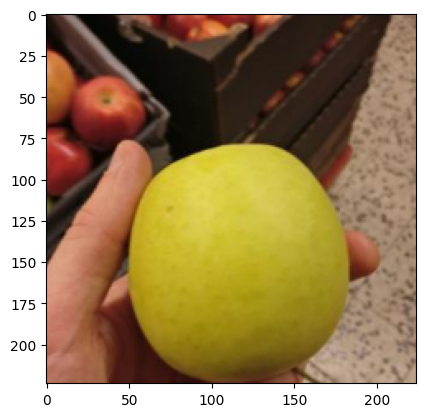

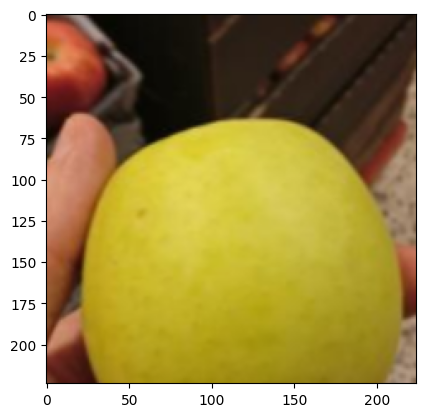

In [34]:
def zoom(img, zoom_center=None, zoom_pixel=35):
    img_copy = img.copy()
    zoom_tot = img.shape[0] // 2 - zoom_pixel
    
    if zoom_center == None:
        cx = img_copy.shape[0] // 2
        cy = img_copy.shape[1] // 2
    else:
        cx = zoom_center[0]
        cy = zoom_center[y]

    #img_copy = cv2.circle(img_copy, (cx + zoom_tot, cy - zoom_tot), 5, 255)
    #print(zoom_pixel, zoom_tot)
    #print(cx, cy, (cx + zoom_tot, cy - zoom_tot))
    
    pts1 = np.float32([(cx - zoom_tot, cy - zoom_tot), (cx + zoom_tot, cy - zoom_tot), (cx + zoom_tot, cy + zoom_tot), (cx - zoom_tot, cy + zoom_tot)])
    pts2 = np.float32([(0, 0), (img_copy.shape[0], 0), (img_copy.shape[0], img_copy.shape[1]), (0, img_copy.shape[1])])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(img_copy, M, (img.shape[0], img.shape[1]))
    
    return dst

img0 = X_train_augmented[0].copy()
img0_zoom = zoom(img0)

plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img0_zoom, cv2.COLOR_BGR2RGB))
plt.show()

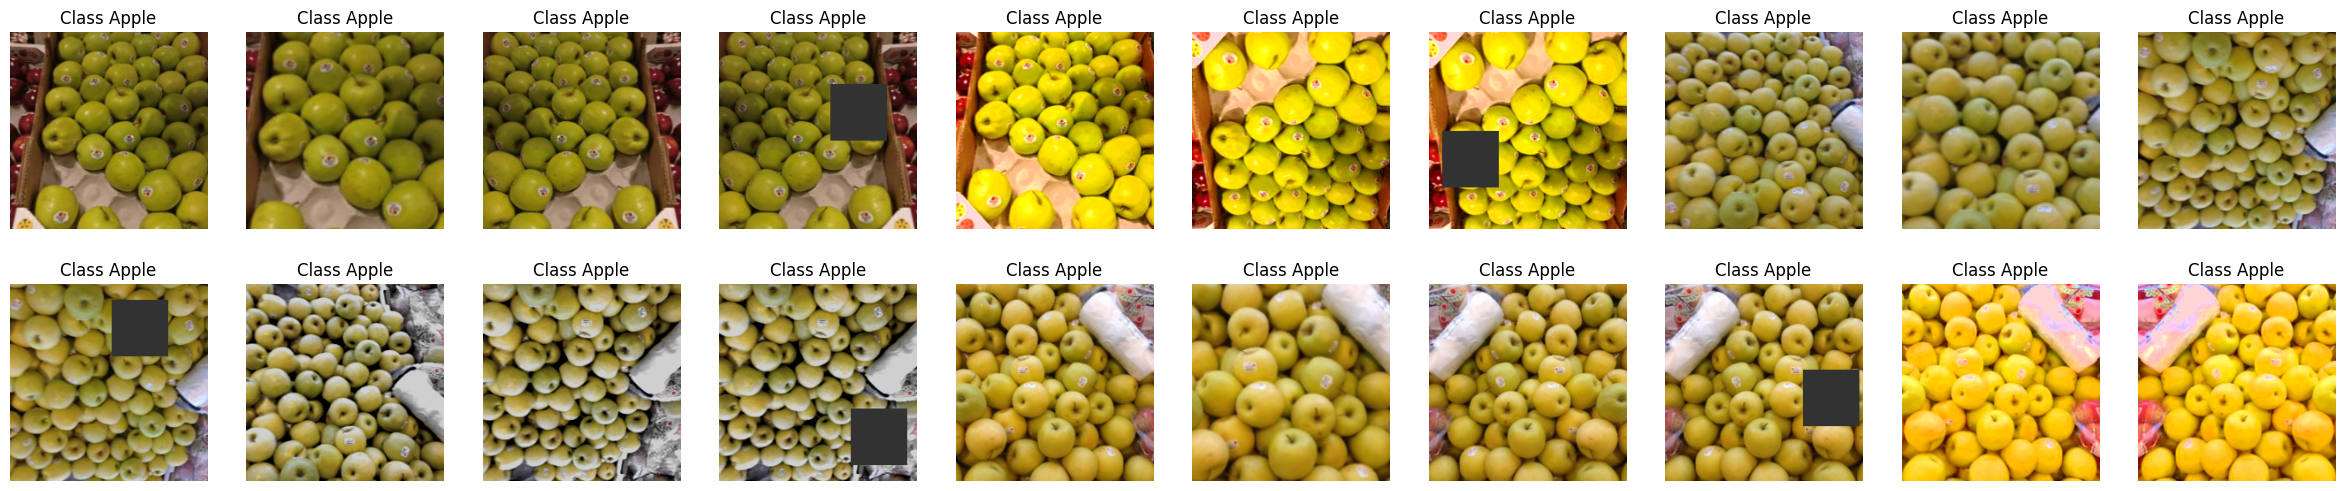

In [33]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()
for i, idx in enumerate(range(70, 90)):
    #rand_idx = np.random.randint(0, X_train.shape[0])
    ax[i].set_axis_off()
    ax[i].set_title(f"Class {labels_coarse[y_train_augmented[idx]]}")
    ax[i].imshow(cv2.cvtColor(X_train_augmented[idx], cv2.COLOR_BGR2RGB))